In [14]:
import numpy as np
from scipy.special import ndtr
from scipy.stats import norm, ncx2
from scipy.optimize import minimize
from numpy.polynomial.hermite import hermfit, hermval, hermder
import copy
import fixed_income_derivatives as fid
import matplotlib.pyplot as plt

#### Spot rates to ZCB


In [14]:
def spot_rates_to_zcb(T,spot_rate):
    M = len(T)
    p = np.zeros([M])
    for i in range(0,M):
        if T[i] < 1e-8:
            p[i] = 1
        else:
            p[i] = np.exp(-spot_rate[i]*T[i])
    return p

#Example:
T = [1/4, 2/4, 3/4, 4/4]
spot_rate = [ 1.42669978,  0.4462871 ,  0.14048069, -0.        ]

print(spot_rates_to_zcb(T,spot_rate))

[0.7 0.8 0.9 1. ]


Input:
\begin{equation*}
\begin{aligned}
T &= \text{time to maturity} \\
\text{spot\_rate}&=\text{Spot rate}
\end{aligned}
\end{equation*}

Output:
\begin{equation*}
\begin{aligned}
p &= \text{ZCB price} 
\end{aligned}
\end{equation*}

Formula:
\begin{equation*}
\begin{aligned}
p(t,T)=\exp(-R(t,T)\cdot(T-t))
\end{aligned}
\end{equation*}


#### ZCB to spot rates

In [13]:
def zcb_to_spot_rates(T,p):
    M = len(T)
    R = np.zeros([M])
    for i in range(0,M):
        if T[i] < 1e-8:
            R[i] = 0
        else:
            R[i] = -np.log(p[i])/T[i]
    return R

#Example:
T = [1/4, 2/4, 3/4, 4/4]
p = [0.7, 0.8, 0.9, 1]

print(zcb_to_spot_rates(T,p))

[ 1.42669978  0.4462871   0.14048069 -0.        ]


Input:
\begin{equation*}
\begin{aligned}
T &= \text{time to maturity} \\
p &= \text{ZCB price} 
\end{aligned}
\end{equation*}

Output:
\begin{equation*}
\begin{aligned}
R &= \text{spot rate} 
\end{aligned}
\end{equation*}

Formula:
\begin{equation*}
\begin{aligned}
R(t,T) &= -\frac{\log p(t,T)}{(T-t)}
\end{aligned}
\end{equation*}


#### ZCB to forward rates

In [22]:
def zcb_to_forward_rates(T,p,horizon = 1):
    # horizon = 0 corresponds to instantaneous forward rates
    M = len(T)
    f = np.zeros([M])
    if horizon == 0:
        f[0] = (np.log(p[0])-np.log(p[1]))/(T[1]-T[0])
        f[-1] = (np.log(p[-2])-np.log(p[-1]))/(T[-1]-T[-2])
        m = 1
        while m < M - 1.5: #1.5 is abritrary and might as well be 1.0001, as far as I understand...
            f[m] = (np.log(p[m-1])-np.log(p[m+1]))/(T[m+1]-T[m-1])
            m += 1
    elif 0 < horizon:
        m = horizon
        while m < M - 0.5:
            f[m] = (np.log(p[m-horizon])-np.log(p[m]))/(T[m]-T[m-horizon])
            m += 1
    return f

#Example:
T = [1/4, 2/4, 3/4, 4/4]
p = [0.7, 0.8, 0.9, 1]

print(zcb_to_forward_rates(T,p, horizon=1))
print(zcb_to_forward_rates(T,p, horizon=0))

[ 0.         -0.53412557 -0.47113214 -0.42144206]
[-0.53412557 -0.50262886 -0.4462871  -0.42144206]


Input:
\begin{equation*}
\begin{aligned}
T &= \text{time to maturity} \\
p &= \text{ZCB price} \\
horizon&=\text{start date of loan}
\end{aligned}
\end{equation*}

Output:
\begin{equation*}
\begin{aligned}
f=\text{forward rates of return}
\end{aligned}
\end{equation*}

Formula:
\begin{equation*}
\begin{aligned}
R(t;S,T)=-\frac{\log p(t,T)-\log p(t,S)}{(T-S)}
\end{aligned}
\end{equation*}


#### ZCB to forward LIBOR rates

In [24]:
def zcb_to_forward_LIBOR_rates(T,p,horizon = 1):
    M = len(T)
    f = np.zeros([M])
    i = horizon
    #ERROR: Need to include what happens when horizon = 0
    while i < M - 0.5:
        f[i] = (p[i-horizon]-p[i])/(p[i]*(T[i]-T[i-horizon]))
        i += 1
    return f

#Example:
T = [1/4, 2/4, 3/4, 4/4]
p = [0.7, 0.8, 0.9, 1]

print(zcb_to_forward_LIBOR_rates(T,p, horizon=1))


[ 0.         -0.5        -0.44444444 -0.4       ]


Input:
\begin{equation*}
\begin{aligned}
T &= \text{time to maturity} \\
p &= \text{ZCB price} \\
horizon&=\text{start date of loan}
\end{aligned}
\end{equation*}

Output:
\begin{equation*}
\begin{aligned}
f=\text{forward rates of return}
\end{aligned}
\end{equation*}

Formula (unsure):
\begin{equation*}
\begin{aligned}
\text{Forward LIBOR Rate} = \frac{p(t, S) - p(t, T)}{p(t, T) \cdot (T - S)}
\end{aligned}
\end{equation*}


#### Utility function used in many of the following functions:

In [85]:
def value_in_list_returns_I_idx(value,list):
    output = False, None
    for i, item in enumerate(list):
        if abs(value-item) < 1e-6:
            output = True, i
            break
    return output

#Example:
example_list = [1/8, 2/8, 3/8, 4/8, 5/8, 6/8, 7/8, 8/8]
example_value = [2/8, 4/8, 6/8, 8/8]

for i in range(0,len(example_value)):
    I_fix, idx_fix = value_in_list_returns_I_idx(example_value[i], example_list)
    if I_fix is True:
        print(example_list[idx_fix])

0.25
0.5
0.75
1.0


In essence, the function only returns values that are in both lists.

#### ZCB to accrual factor (also known as present value of a basis point)

In [127]:
def zcb_to_accrual_factor(T_n,T_N,fixed_freq,T,p):
    if fixed_freq == "quarterly":
        p_fix = np.zeros([int(T_N-T_n)*4])
        T_fix = np.array([T_n + i*0.25 for i in range(1,int(T_N-T_n)*4 + 1)])
    elif fixed_freq == "semiannual":
        p_fix = np.zeros([int(T_N-T_n)*2])
        T_fix = np.array([T_n + i*0.5 for i in range(1,int(T_N-T_n)*2 + 1)])
    elif fixed_freq == "annual":
        p_fix = np.zeros([int(T_N-T_n)])
        T_fix = np.array([T_n + i*0.25 for i in range(1,int(T_N-T_n) + 1)])
    S = 0
    for i in range(0,len(T_fix)):
        I_fix, idx_fix = value_in_list_returns_I_idx(T_fix[i],T)
        if I_fix is True:
            T_fix[i] = T[idx_fix]
            p_fix[i] = p[idx_fix]
            if i == 0:
                S += T_fix[i]*p_fix[i]
            else:
                S += (T_fix[i]-T_fix[i-1])*p_fix[i]


    return S

#Example:
T = [1/4, 2/4, 3/4, 4/4]
p = [0.7, 0.8, 0.9, 1]

S = zcb_to_accrual_factor(0,1,"quarterly",T,p)

print(S)


0.85


Input:
\begin{equation*}
\begin{aligned}
T_n &= \text{Start time of the accrual period} \\
T_N &= \text{End time of the accrual period} \\
\text{fixed\_freq} &= \text{Frequency of accrual} \\
T &= \text{time to maturity} \\
p &= \text{ZCB price}
\end{aligned}
\end{equation*}

Output:
\begin{equation*}
\begin{aligned}
S=\text{Accrual factor}
\end{aligned}
\end{equation*}

Formula:
\begin{equation*}
\begin{aligned}
S_{n}^{k}(t) &=\sum_{i=n+1}^{k}\alpha_{i}p(t,T_{i}) \\
\alpha_{i} &=T_{i}-T_{i-1}
\end{aligned}
\end{equation*}

where $n$ is the start period and $k$ is the end period.


#### ZCB to par swap rate

In [129]:
def zcb_to_par_swap_rate(T_n,T_N,fixed_freq,T,p):
    I_n, idx_n = value_in_list_returns_I_idx(T_n,T)
    I_N, idx_N = value_in_list_returns_I_idx(T_N,T)
    D = p[idx_n]-p[idx_N]
    S = zcb_to_accrual_factor(T_n,T_N,fixed_freq,T,p)
    R = D/S
    return R

#Example:
T = [0, 1/4, 2/4, 3/4, 4/4]
p = [0.5, 0.7, 0.8, 0.9, 1]

zcb_to_par_swap_rate(0,1,"quarterly",T,p)

-0.5882352941176471

Input:
\begin{equation*}
\begin{aligned}
T_n &= \text{Start time of the accrual period} \\
T_N &= \text{End time of the accrual period} \\
\text{fixed\_freq} &= \text{Frequency of accrual} \\
T &= \text{time to maturity} \\
p &= \text{ZCB price}
\end{aligned}
\end{equation*}

Output:
\begin{equation*}
\begin{aligned}
R=\text{Par swap rate}
\end{aligned}
\end{equation*}

Formula:
\begin{equation*}
\begin{aligned}
R_{n}^{N}(t)=\frac{p_{n}(t)-p_{N}(t)}{\sum_{i=n+1}^{N}\alpha_{i}p_{i}(t)}
\end{aligned}
\end{equation*}

where $n$ is the start period and $N$ is the end period. Note that the denominator is the accrual rate.


#### ZCB price for vasicek

In [144]:
def zcb_price_vasicek(r0,a,b,sigma,tau):
    if type(tau) == int or type(tau) == float:
        B = (1/a)*(1-np.exp(-a*tau))
        A = (B-tau)*(a*b-0.5*sigma**2)/(a**2)-(sigma**2*B)/(4*a)
        p = np.exp(A-r0*B)
    elif type(tau) == tuple or type(tau) == list or type(tau) == np.ndarray:
        M = len(tau)
        p = np.zeros([M])
        for i in range(0,M):
            B = (1/a)*(1-np.exp(-a*tau[i]))
            A = (B-tau[i])*(a*b-0.5*sigma**2)/(a**2)-(sigma**2*B)/(4*a)
            #ERROR: Why is it not B**2????
            p[i] = np.exp(A-r0*B)
    else:
        print(f"tau not a recognized type")
        p = False
    return p

#Example:
r0, a, b, sigma_vasicek = 0.025, 0.5, 0.025, 0.02
alpha = 0.25
T_max = 10

M = int(round(T_max/alpha))

T = np.array([i*alpha for i in range(0,M+1)])

print(zcb_price_vasicek(r0, a, b, sigma_vasicek, T))

[1.         0.99336228 0.98611486 0.97834796 0.97014137 0.96156554
 0.9526825  0.94354674 0.93420609 0.9247024  0.91507227 0.90534762
 0.89555625 0.88572234 0.87586689 0.86600808 0.85616164 0.84634112
 0.83655822 0.82682295 0.81714389 0.80752836 0.79798256 0.78851175
 0.77912033 0.76981198 0.76058975 0.75145611 0.74241308 0.73346224
 0.72460482 0.71584171 0.70717356 0.69860077 0.69012352 0.68174184
 0.67345559 0.6652645  0.6571682  0.64916622 0.64125799]


Input:
\begin{equation*}
\begin{aligned}
r_0 &= \text{Initial short rate} \\
a &= \text{Speed of reversion} \\
b &= \text{Long-term mean level} \\
\sigma &= \text{Volatility} \\
\tau &= \text{Time to maturity}
\end{aligned}
\end{equation*}

Output:
\begin{equation*}
p = \text{Price of the ZCB}
\end{equation*}

Formula:
\begin{equation*}
p(t, T) = e^{A(t,T)-B(t,T)r(t)}
\end{equation*}
where
\begin{equation*}
\begin{aligned}
A(t,T)&=\frac{\left[B(t,T)-(T-t)\right]\left(ab-\frac{1}{2}\sigma^{2}\right)}{a^{2}}-\frac{\sigma^{2}B^{2}(t,T)}{4a}\\
B(t, T) &= \frac{1}{a}\left[1 - e^{-a(T-t)}\right]
\end{aligned}
\end{equation*}

#### Spot rate for vasicek

In [142]:
def spot_rate_vasicek(r0,a,b,sigma,tau):
    if type(tau) == int or type(tau) == float:
        B = (1/a)*(1-np.exp(-a*tau))
        A = (B-tau)*(a*b-0.5*sigma**2)/(a**2)-(sigma**2*B)/(4*a)
        if tau < 1e-6:
            r = 0
        elif tau >= 1e-6:
            r = (-A+r0*B)/tau
    elif type(tau) == tuple or type(tau) == list or type(tau) == np.ndarray:
        M = len(tau)
        r = np.zeros([M])
        for i in range(0,M):
            B = (1/a)*(1-np.exp(-a*tau[i]))
            A = (B-tau[i])*(a*b-0.5*sigma**2)/(a**2)-(sigma**2*B)/(4*a)
            if tau[i] < 1e-6:
                r[i] = 0
            else:
                r[i] = (-A+r0*B)/tau[i]
    else:
        print(f"tau not a recognized type")
        r = False
    return r

#Example:
r0, a, b, sigma_vasicek = 0.025, 0.5, 0.025, 0.02
alpha = 0.25
T_max = 10

M = int(round(T_max/alpha))

T = np.array([i*alpha for i in range(0,M+1)])

print(spot_rate_vasicek(r0, a, b, sigma_vasicek, T))

[0.         0.02663941 0.02796488 0.02918651 0.03031347 0.03135404
 0.03231573 0.03320536 0.03402911 0.03479259 0.03550089 0.03615865
 0.03677008 0.037339   0.0378689  0.03836294 0.03882402 0.03925477
 0.03965759 0.04003467 0.04038802 0.04071945 0.04103064 0.04132313
 0.0415983  0.04185744 0.04210172 0.04233222 0.04254992 0.04275575
 0.04295051 0.04313499 0.04330989 0.04347586 0.04363349 0.04378334
 0.04392591 0.04406168 0.04419108 0.04431451 0.04443234]


Input: Same as above

Output: Spot rate

Formula:

\begin{equation*}
R(t,T)=\frac{-A(t,T)+rB(t,T)}{T-t}
\end{equation*}

where $A$ and $B$ are the same as above.

#### Forward rate vasicek

In [145]:
def forward_rate_vasicek(r0,a,b,sigma,tau):
    if type(tau) == int or type(tau) == float:
        B = (1/a)*(1-np.exp(-a*tau))
        B_T = np.exp(-a*tau)
        if tau < 1e-6:
            f = 0
        elif tau >= 1e-6:
            f = (1-B_T)*(a*b-0.5*sigma**2)/(a**2) + (sigma**2*B*B_T)/(2*a) + r0*B_T
    elif type(tau) == tuple or type(tau) == list or type(tau) == np.ndarray:
        M = len(tau)
        f = np.zeros([M])
        for i in range(0,M):
            B = (1/a)*(1-np.exp(-a*tau[i]))
            B_T = np.exp(-a*tau[i])
            if tau[i] < 1e-6:
                f[i] = 0
            else:
                f[i] = (1-B_T)*(a*b-0.5*sigma**2)/(a**2) + (sigma**2*B*B_T)/(2*a) + r0*B_T
    else:
        print(f"tau not a recognized type")
        f = False
    return f

#Example:
r0, a, b, sigma_vasicek = 0.025, 0.5, 0.025, 0.02
alpha = 0.25
T_max = 10

M = int(round(T_max/alpha))

T = np.array([i*alpha for i in range(0,M+1)])

print(forward_rate_vasicek(r0, a, b, sigma_vasicek, T))

[0.         0.02792653 0.03049084 0.03273954 0.03471288 0.03644568
 0.03796812 0.03930641 0.04048335 0.04151881 0.04243012 0.04323241
 0.04393892 0.04456125 0.04510953 0.04559268 0.0460185  0.04639386
 0.04672477 0.04701654 0.04727382 0.04750071 0.04770082 0.04787732
 0.048033   0.04817033 0.04829148 0.04839836 0.04849265 0.04857584
 0.04864924 0.048714   0.04877115 0.04882157 0.04886605 0.04890531
 0.04893995 0.04897052 0.04899749 0.04902129 0.0490423 ]


Input: Same as above

Output: Forward rate

Formula:

\begin{equation*}
f(t,T)=\frac{(1-B_{T})(ab-\frac{1}{2}\sigma^{2})}{a^{2}}+\frac{\sigma^{2}BB_{T}}{2a}+rB_{t}
\end{equation*}

where $A$ and $B$ are the same as above and $B_{t}=\exp(-a\cdot(T-t))$



#### Confidence intervals for vasicek

In [35]:
def ci_vasicek(r0,a,b,sigma,T,size_ci,method = "two_sided"):
    if type(T) == int or type(T) == float:
        if method == "lower":
            z = norm.ppf(size_ci,0,1)
            if T < 1e-6:
                lb, ub = np.nan, np.nan
            else:
                mean = r0*np.exp(-a*T) + b/a*(1-np.exp(-a*T))
                std = np.sqrt(sigma**2/(2*a)*(1-np.exp(-2*a*T)))
                lb, ub = mean - z*std, np.inf
        elif method == "upper":
            z = norm.ppf(size_ci,0,1)
            if T < 1e-6:
                lb, ub = np.nan, np.nan
            else:
                mean = r0*np.exp(-a*T) + b/a*(1-np.exp(-a*T))
                std = np.sqrt(sigma**2/(2*a)*(1-np.exp(-2*a*T)))
                lb, ub = -np.inf, mean + z*std
        elif method == "two_sided":
            z = norm.ppf(size_ci + 0.5*(1-size_ci),0,1)
            if T < 1e-6:
                lb, ub = np.nan, np.nan
            else:
                mean = r0*np.exp(-a*T) + b/a*(1-np.exp(-a*T))
                std = np.sqrt(sigma**2/(2*a)*(1-np.exp(-2*a*T)))
                lb, ub = mean - z*std, mean + z*std
        print(f"method: {method}, z: {z}")
    elif type(T) == tuple or type(T) == list or type(T) == np.ndarray:
        N = len(T)
        lb, ub = np.zeros([N]), np.zeros([N])
        if method == "lower":
            z = norm.ppf(size_ci,0,1)
            for i in range(0,N):
                if T[i] < 1e-6:
                    lb[i], ub[i] = np.nan, np.nan
                else:
                    mean = r0*np.exp(-a*T[i]) + b/a*(1-np.exp(-a*T[i]))
                    std = np.sqrt(sigma**2/(2*a)*(1-np.exp(-2*a*T[i])))
                    lb[i], ub[i] = mean - z*std, np.inf
        elif method == "upper":
            z = norm.ppf(size_ci,0,1)
            for i in range(0,N):
                if T[i] < 1e-6:
                    lb[i], ub[i] = np.nan, np.nan
                else:
                    mean = r0*np.exp(-a*T[i]) + b/a*(1-np.exp(-a*T[i]))
                    std = np.sqrt(sigma**2/(2*a)*(1-np.exp(-2*a*T[i])))
                    lb[i], ub[i] = -np.inf, mean + z*std
        elif method == "two_sided":
            z = norm.ppf(size_ci + 0.5*(1-size_ci),0,1)
            for i in range(0,N):
                if T[i] < 1e-6:
                    lb[i], ub[i] = np.nan, np.nan
                else:
                    mean = r0*np.exp(-a*T[i]) + b/a*(1-np.exp(-a*T[i]))
                    std = np.sqrt(sigma**2/(2*a)*(1-np.exp(-2*a*T[i])))
                    lb[i], ub[i] = mean - z*std, mean + z*std
    else:
        print(f"tau not a recognized type")
        lb,ub = False, False
    return lb, ub, 


#Example:
r0, a, b, sigma_vasicek = 0.025, 0.5, 0.025, 0.02
alpha = 0.25
T_max = 10

M = int(round(T_max/alpha))

T = np.array([i*alpha for i in range(0,M+1)])

lb, ub = ci_vasicek(r0, a, b, sigma_vasicek, T, 0.95, method = "two_sided")

print(lb)
print(ub)


[       nan 0.00950144 0.0059414  0.00434405 0.00367095 0.00350736
 0.0036405  0.00394749 0.00435264 0.0048077  0.00528138 0.00575339
 0.00621073 0.0066454  0.00705277 0.00743053 0.00777798 0.00809547
 0.00838408 0.0086453  0.00888088 0.00909271 0.00928271 0.00945275
 0.00960466 0.00974015 0.00986084 0.00996822 0.01006366 0.01014841
 0.01022362 0.01029031 0.0103494  0.01040175 0.0104481  0.01048912
 0.01052541 0.01055751 0.0105859  0.01061099 0.01063316]
[       nan 0.04637371 0.05511857 0.06129149 0.06600252 0.06972956
 0.07274117 0.07520941 0.07725339 0.07895968 0.08039338 0.08160464
 0.08263276 0.08350901 0.08425854 0.08490172 0.08545526 0.08593288
 0.08634596 0.08670398 0.08701487 0.0872853  0.0875209  0.08772645
 0.08790599 0.088063   0.08820045 0.08832087 0.08842647 0.08851913
 0.08860049 0.08867198 0.08873481 0.08879007 0.08883869 0.08888147
 0.08891914 0.0889523  0.08898152 0.08900726 0.08902994]


Input: Same as above, except with the following included:

\begin{equation*}
\begin{aligned}
\text{size\_ci}&=\text{size of confidenceinterval, i.e. 0.95 as 95\% confidence interval} \\
\text{method}&=\text{for either one or two-sided confidence interval}
\end{aligned}
\end{equation*}

Output: Upper and lower confidence interval of the short rate

Formula:

\begin{equation*}
\begin{aligned}
\text{mean}&=r_{0}\cdot\exp\left(-a\cdot(T-t)\right)+\frac{b}{a}\cdot\left(1-\exp\left[-a\cdot(T-t)\right]\right) \\
\text{std.}&=\sqrt{\frac{\sigma^{2}}{2\cdot a}\cdot\left(1-\exp\left[-a\cdot(T-t)\right]\right)}
\end{aligned}
\end{equation*}

Of course, the confidence intervals are drawn from a normal distribution and calculated as $\text{mean}=\text{std.}\cdot\text{quantile}(0.95,\mathcal{N}(0,1))$

The code is horrible written and basically repeats itself six times

#### Euro option price for vasicek

In [ ]:
def euro_option_price_vasicek(K,T,U,p_T,p_U,a,sigma,type = "call"):
    sigma_p = (sigma/a)*(1-np.exp(-a*(U-T)))*np.sqrt((1-np.exp(-2*a*T))/(2*a))
    d1 = (np.log(p_U/(p_T*K)))/sigma_p + 0.5*sigma_p
    d2 = d1 - sigma_p
    if type == "call":
        price = p_U*ndtr(d1) - p_T*K*ndtr(d2)
    elif type == "put":
        price = p_T*K*ndtr(-d2) - p_U*ndtr(-d1)
    return price

#Example: Not right now

Calculate the following (from slides):
"We would like to price a European call optioon with strike $K$ and maturity $T_1$ on an underlying zero coupon bond with maturity $T_2$.

In the notation of the previous discussion, we have that $T=T_1$, $S(t)=p(t,T_2)$ and must use $p(t,T_1)$ as numeraire" 

Input:

\begin{equation*}
\begin{aligned}
K&=\text{strike price} \\
U&=T_{1} \\
T&=T_{2} \\
p_{T}&=p(0,T_{2}) \\
p_{U}&=p(0,T_{1})
\end{aligned}
\end{equation*}

Output: The price of the European call option

Formula: Using the notation from slides and rewriting, we get:

\begin{equation*}
\begin{aligned}
\text{Call: }\Pi(0;\chi)&=p(0,T_{2})\Phi(d_{1})-Kp(0,T_{1})\Phi(d_{2}) \\

\text{Put: }\Pi(0;\chi)&=p(0,T_{1})K\Phi(-d_{2})-p(0,T_{2})\Phi(-d_{1}) \\

d_{1} &=\frac{\ln\left(\frac{p(0,T_{2})}{Kp(0,T_{1})}\right)+\frac{1}{2}\Sigma^{2}}{\sqrt{\Sigma^{2}}}=\frac{\ln\left(\frac{p(0,T_{2})}{Kp(0,T_{1})}\right)}{\Sigma}+\frac{1}{2}\Sigma\quad\text{and}\quad d_{2}=d_{1}-\sqrt{\Sigma^{2}}=d_{1}-\Sigma \\

\Sigma^{2}&=\frac{\sigma^{2}}{2a^{3}}\left[1-e^{2aT_{1}}\right]\cdot\left[1-e^{-a(T_{2}-T_{1})}\right]^{2}\Leftrightarrow \\

\Sigma &=\frac{\sigma}{a}\cdot\left[1-e^{-a(T_{2}-T_{1})}\right]\sqrt{\frac{1}{2a}\left[1-e^{2aT_{1}}\right]}
\end{aligned}
\end{equation*}

Here, $\Phi$ is the cumulative distribution of the standard normal distribution, and we use the scipy Python function 'ndtr' to calculate this.

#### Fit vasicek object (calculate squared errors)

In [ ]:
def fit_vasicek_obj(param,R_star,T,scaling = 1):
    r0, a, b, sigma = param
    M = len(T)
    R_fit = spot_rate_vasicek(r0,a,b,sigma,T)
    y = 0
    for m in range(0,M):
        y += scaling*(R_fit[m] - R_star[m])**2
    return y

The functions simply returns the squared errors of between a fitted model and actual data. It is used to optimize the parameters of our vasicek model so it fits to real data.

Input:

\begin{equation*}
\begin{aligned}
\text{param}&=\text{Parameters that we want to optimize over} \\

\text{R\_star}&=\text{Actual data we need to fit our model over} \\

T&=\text{Time to maturity} \\

\text{scaling}&=\text{We might want to scale our data if errors are too small or too large for the optimizer}
\end{aligned}
\end{equation*}

Output: Squared errors (scaled if needed)

In [ ]:
def fit_vasicek_no_sigma_obj(param,sigma,R_star,T,scaling = 1):
    r0, a, b = param
    M = len(T)
    R_fit = spot_rate_vasicek(r0,a,b,sigma,T)
    y = 0
    for m in range(0,M):
        y += scaling*(R_fit[m] - R_star[m])**2
    return y

Same as above, just without $\sigma$

#### ZCB for Cox-Ingersoll-Ross model
The following models are essentially the same as above, and I will therefore only provide the formulas. Remember that the CIR model has the following dynamics:

\begin{equation*}
dr_{t}=(b-ar_{t})dt+\sigma\sqrt{r_{t}}dB_{t}
\end{equation*}

In [ ]:
def zcb_price_cir(r0,a,b,sigma,tau):
    if type(tau) == int or type(tau) == float or type(tau) == np.float64:
        gamma = np.sqrt(a**2+2*sigma**2)
        D = (gamma+a)*(np.exp(gamma*tau)-1)+2*gamma
        A = ((2*gamma*np.exp(0.5*tau*(a+gamma)))/D)**((2*a*b)/(sigma**2))
        B = 2*(np.exp(gamma*tau)-1)/D
        p = A*np.exp(-r0*B)
    elif type(tau) == tuple or type(tau) == list or type(tau) == np.ndarray:
        M = len(tau)
        p = np.zeros([M])
        for i in range(0,M):
            gamma = np.sqrt(a**2+2*sigma**2)
            D = (gamma+a)*(np.exp(gamma*tau[i])-1)+2*gamma
            A = ((2*gamma*np.exp(0.5*tau[i]*(a+gamma)))/D)**((2*a*b)/(sigma**2))
            B = 2*(np.exp(gamma*tau[i])-1)/D
            p[i] = A*np.exp(-r0*B)
    else:
        print(f"tau not a recognized type")
        p = False
    return p

Formula:

\begin{equation*}
\begin{aligned}
p(t,T)&=A_{0}(T-t)e^{-B(T-t)r} \\
\end{aligned}
\end{equation*}

where

\begin{equation*}
\begin{aligned}
A_{0}(T-t)&=\left[\frac{2\gamma\exp\left(\frac{(T-t)(a+\gamma)}{2}\right)}{D}\right]^{\frac{2ab}{\sigma^{2}}} \\

B(T-t)&=\frac{2\left(\exp[\gamma(T-t)]-1\right)}{D} \\

D&=(\gamma+a)\left(\exp[\gamma(T-t)]-1\right)+2\gamma \\
\gamma&=\sqrt{a^{2}+2\sigma^{2}}
\end{aligned}
\end{equation*}


#### Spot rate for Cox-Ingersoll-Ross model

In [ ]:
def spot_rate_cir(r0,a,b,sigma,tau):
    if type(tau) == int or type(tau) == float:
        if tau < 1e-6:
            r = 0
        else:
            gamma = np.sqrt(a**2+2*sigma**2)
            D = (gamma+a)*(np.exp(gamma*tau)-1)+2*gamma
            A = ((2*gamma*np.exp(0.5*tau*(a+gamma)))/D)**((2*a*b)/(sigma**2))
            B = 2*(np.exp(gamma*tau)-1)/D
            r = (-np.log(A)+r0*B)/(tau)
    elif type(tau) == tuple or type(tau) == list or type(tau) == np.ndarray:
        M = len(tau)
        r = np.zeros([M])
        for i in range(0,M):
            if tau[i] < 1e-6:
                r[i] = 0
            else:
                gamma = np.sqrt(a**2+2*sigma**2)
                D = (gamma+a)*(np.exp(gamma*tau[i])-1)+2*gamma
                A = ((2*gamma*np.exp(0.5*tau[i]*(a+gamma)))/D)**((2*a*b)/(sigma**2))
                B = 2*(np.exp(gamma*tau[i])-1)/D
                r[i] = (-np.log(A)+r0*B)/(tau[i])
    else:
        print(f"tau not a recognized type")
        r = False
    return r

Formula:

\begin{equation*}
R(t,T)=\frac{-\log A_{0}+rB}{T-t}
\end{equation*}

where $A_{0}$ and $B$ are the same as above.

#### Forward rate for Cox-Ingersoll-Ross model

In [ ]:
def forward_rate_cir(r0,a,b,sigma,tau):
    if type(tau) == int or type(tau) == float:
        if tau < 1e-6:
            f = 0
        else:
            c = (2*a*b)/(sigma**2)
            gamma = np.sqrt(a**2+2*sigma**2)
            N = 2*gamma*np.exp(0.5*tau*(a+gamma))
            N_T = gamma*(gamma+a)*np.exp(0.5*tau*(a+gamma))
            D = (gamma+a)*(np.exp(gamma*tau)-1)+2*gamma
            D_T = gamma*(a+gamma)*np.exp(gamma*tau)
            M = 2*(np.exp(gamma*tau)-1)
            M_T = 2*gamma*np.exp(gamma*tau)
            f = c*(-N_T/N+D_T/D)+r0*(M_T*D-M*D_T)/D**2
    elif type(tau) == tuple or type(tau) == list or type(tau) == np.ndarray:
        N = len(tau)
        f = np.zeros([N])
        for i in range(0,N):
            if tau[i] < 1e-6:
                f[i] = 0
            else:
                c = (2*a*b)/(sigma**2)
                gamma = np.sqrt(a**2+2*sigma**2)
                N = 2*gamma*np.exp(0.5*tau[i]*(a+gamma))
                N_T = gamma*(gamma+a)*np.exp(0.5*tau[i]*(a+gamma))
                D = (gamma+a)*(np.exp(gamma*tau[i])-1)+2*gamma
                D_T = gamma*(a+gamma)*np.exp(gamma*tau[i])
                M = 2*(np.exp(gamma*tau[i])-1)
                M_T = 2*gamma*np.exp(gamma*tau[i])
                f[i] = c*(-N_T/N+D_T/D)+r0*(M_T*D-M*D_T)/D**2
    else:
        print(f"tau not a recognized type")
        f = False
    return f

Formula:

\begin{equation*}
\begin{aligned}
f(t,T)=c\left(-\frac{N_{t}}{N}+\frac{D_{t}}{D}\right)+rB_{t}
\end{aligned}
\end{equation*}

where

\begin{equation*}
\begin{aligned}
N_{t}&=\gamma(a+\gamma)\cdot\exp\left(\frac{(T-t)(a+\gamma)}{2}\right) \\

N&=2\gamma\cdot\exp\left(\frac{(T-t)(a+\gamma)}{2}\right) \\

D_{t}&=\gamma(\gamma+a)\cdot\exp(\gamma(T-t)) \\

D&=(\gamma+a)\left(\exp[\gamma(T-t)]-1\right)+2\gamma \\

B_{T}&=\frac{M_{T}D-MD_{T}}{D^{2}} \\

c&=\frac{2ab}{\sigma^{2}} \\
\end{aligned}
\end{equation*}

Niether $c$ or $N$ are defined in the slides.

#### Confidence intervals for Cox-Ingersoll-Ross

In [ ]:
def ci_cir(r0,a,b,sigma,tau,size_ci,method = "two_sided"):
    if type(tau) == int or type(tau) == float:
        if method == "lower":
            if tau < 1e-6:
                lb, ub = np.nan, np.nan
            else:
                df = (4*a*b)/sigma**2
                nc = (4*a*np.exp(-a*tau)*r0)/(sigma**2*(1-np.exp(-a*tau)))
                scaling = (4*a)/(sigma**2*(1-np.exp(-a*tau)))
                lb, ub = ncx2.ppf(1-size_ci,df,nc)/scaling, np.inf
        elif method == "upper":
            if tau < 1e-6:
                lb, ub = np.nan, np.nan
            else:
                df = (4*a*b)/sigma**2
                nc = (4*a*np.exp(-a*tau)*r0)/(sigma**2*(1-np.exp(-a*tau)))
                scaling = (4*a)/(sigma**2*(1-np.exp(-a*tau)))
                lb, ub = 0, ncx2.ppf(size_ci,df,nc)/scaling
        elif method == "two_sided":
            if tau < 1e-6:
                lb, ub = np.nan, np.nan
            else:
                df = (4*a*b)/sigma**2
                nc = (4*a*np.exp(-a*tau)*r0)/(sigma**2*(1-np.exp(-a*tau)))
                scaling = (4*a)/(sigma**2*(1-np.exp(-a*tau)))
                lb, ub = ncx2.ppf((1-size_ci)/2,df,nc)/scaling, ncx2.ppf(size_ci+(1-size_ci)/2,df,nc)/scaling
    elif type(tau) == tuple or type(tau) == list or type(tau) == np.ndarray:
        N = len(tau)
        lb, ub = np.zeros([N]), np.zeros([N])
        if method == "lower":
            for i in range(0,N):
                if tau[i] < 1e-6:
                    lb[i], ub[i] = np.nan, np.nan
                else:
                    df = (4*a*b)/sigma**2
                    nc = (4*a*np.exp(-a*tau[i])*r0)/(sigma**2*(1-np.exp(-a*tau[i])))
                    scaling = (4*a)/(sigma**2*(1-np.exp(-a*tau[i])))
                    lb[i], ub[i] = ncx2.ppf(1-size_ci,df,nc)/scaling, np.inf
        elif method == "upper":
            for i in range(0,N):
                if tau[i] < 1e-6:
                    lb[i], ub[i] = np.nan, np.nan
                else:
                    df = (4*a*b)/sigma**2
                    nc = (4*a*np.exp(-a*tau[i])*r0)/(sigma**2*(1-np.exp(-a*tau[i])))
                    scaling = (4*a)/(sigma**2*(1-np.exp(-a*tau[i])))
                    lb[i], ub[i] = 0, ncx2.ppf(size_ci,df,nc)/scaling
        elif method == "two_sided":
            for i in range(0,N):
                if tau[i] < 1e-6:
                    lb[i], ub[i] = np.nan, np.nan
                else:
                    df = (4*a*b)/sigma**2
                    nc = (4*a*np.exp(-a*tau[i])*r0)/(sigma**2*(1-np.exp(-a*tau[i])))
                    scaling = (4*a)/(sigma**2*(1-np.exp(-a*tau[i])))
                    lb[i], ub[i] = ncx2.ppf((1-size_ci)/2,df,nc)/scaling, ncx2.ppf(size_ci+(1-size_ci)/2,df,nc)/scaling
                    # (4*b)/(sigma**2*(1-np.exp(-b*tau[i])))*
    else:
        print(f"tau not a recognized type")
        lb,ub = False, False
    return lb, ub

To calculate the confidence intervals for the CIR model, we use a noncentral chi-squared distribution (it's easy to see...). 

\begin{equation*}
\begin{aligned}
\text{df}&=\frac{4ab}{\sigma^{2}} \\

\text{nc}&=\frac{4a\exp(-a(T-t)r)}{\sigma^{2}(1-\exp[-a(T-t)])} \\

\text{scaling}&=\frac{4a}{\sigma^{2}(1-\exp[-a(T-t)])}
\end{aligned}
\end{equation*}

Now we can calculate the upper and lower bounds using the Percent point function (inverse of cdf — percentiles):

\begin{equation*}
lb=\frac{Q(\frac{1-0.95}{2},\text{df},\text{nc})}{\text{scaling}},ub=\frac{Q(0.95+\frac{1-0.95}{2},\text{df},\text{nc})}{\text{scaling}}
\end{equation*}

#### Fit Cox-Ingersoll-Ross object (calculate squared errors)
See the fit for vasicek. The procedure is exactly the same.

In [ ]:
def fit_cir_obj(param,R_star,T,scaling = 1):
    r0, a, b, sigma = param
    M = len(T)
    R_fit = spot_rate_cir(r0,a,b,sigma,T)
    y = 0
    for m in range(0,M):
        y += scaling*(R_fit[m] - R_star[m])**2
    return y

def fit_cir_no_sigma_obj(param,sigma,R_star,T,scaling = 1):
    r0, a, b = param
    M = len(T)
    R_fit = spot_rate_cir(r0,a,b,sigma,T)
    y = 0
    for m in range(0,M):
        y += scaling*(R_fit[m] - R_star[m])**2
    return y

#### Simulation of the short rate

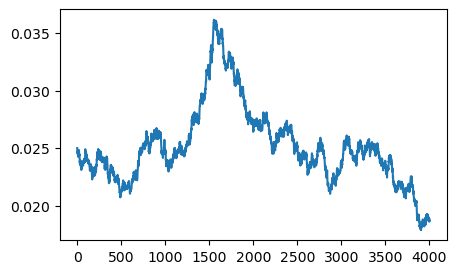

In [11]:
def short_rate_simul(r0,param,M,T,method = "vasicek"):
    r = np.zeros([M+1])
    r[0] = r0
    delta = T/M
    if method == "vasicek":
        a, b, sigma = param
        delta_sqrt = np.sqrt(delta)
        Z = np.random.standard_normal(M)
        for m in range(1,M+1):
            r[m] = r[m-1] + (b-a*r[m-1])*delta + sigma*delta_sqrt*Z[m-1]
    elif method == "cir":
        a, b, sigma = param
        Z = np.random.standard_normal(M)
        for m in range(1,M+1):
            r[m] = r[m-1] + a*(b-r[m-1])*delta + sigma*np.sqrt(delta*r[m-1])*Z[m-1]
    elif method == "ho_lee_ns":
        f_inf, a, b, sigma = param
        Z = np.random.standard_normal(M)
        for m in range(1,M+1):
            param_theta = (f_inf, a, b, sigma)
            theta = fid.theta_ns(param_theta,m*delta)
            r[m] = r[m-1] + theta*delta + sigma*np.sqrt(delta*r[m-1])*Z[m-1]
    return r

#Example:
# a, b, sigma = 0.5, 0.025, 0.02
param = 0.5, 0.025, 0.02

r0 = 0.025

T = 10
M = 4000

simul = short_rate_simul(r0,param,M,T,method="cir")

plt.figure(figsize=(5, 3))
plt.plot(simul)

#NOTE: "ho_lee_ns" option does not work since I don't know how the Nelson-Siegel functions work

Vasicek:
\begin{equation*}
dr_{t} = (b - a r_{t})dt + \sigma \sqrt{r_{t}} dB_{t}
\end{equation*}

Cox-Ingersoll-Ross (CIR) Model:
\begin{equation*}
dr_{t} = a(b - r_{t})dt + \sigma\sqrt{r_{t}}dB_{t}
\end{equation*}

Hull-White Model with Nelson-Siegel term structure:
\begin{equation*}
dr_{t} = \Theta(t)dt + \sigma\sqrt{r_{t}}dB_{t}
\end{equation*}

Now the question is, how do we fit $\Theta$? Currently, I do not understand

#### Black's formula to calculate the Black Schole price

In [ ]:
def bs_price(S, K, T, r, sigma, type = "call"):
    # S: spot price
    # K: strike price
    # T: time to maturity
    # r: interest rate
    # sigma: volatility of underlying asset
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = (np.log(S/K) + (r - 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    if type == 'put':
        price = K*np.exp(-r*T)*ndtr(-d2) - S*ndtr(-d1)
    else:
        price = S*ndtr(d1)-K*np.exp(-r*T)*ndtr(d2)
    return price

Input:

\begin{equation*}
\begin{aligned}
\text{S}&=\text{spot price} \\

\text{K}&=\text{strike price}\\

\text{T}&=\text{time to maturity}\\

\text{r}&=\text{interest rate}\\

\sigma&=\text{volatility of underlying asset}
\end{aligned}
\end{equation*}

Output: Price

Formulas are derived in Linderstrøm (2013):

\begin{equation*}
\begin{aligned}
\text{Put: }p(t,T)&=K\exp(-r(T-t))\cdot\Phi(-d_{2})-S\cdot\Phi(-d_{1}) \\

\text{Call: }p(t,T)&=S\Phi(d_{1})-K\exp(-r(T-t))\cdot\Phi(d_{2}) \\

d_{1}&=\frac{\log\frac{S}{K}+(r+\frac{1}{2}\sigma^{2})\cdot(T-t)}{\sigma\sqrt{T-t}} \\

d_{2}&=\frac{\log\frac{S}{K}+(r-\frac{1}{2}\sigma^{2})\cdot(T-t)}{\sigma\sqrt{T-t}}=d_{1}-\sigma\sqrt{T-t}
\end{aligned}
\end{equation*}

#### Black's vega

In [ ]:
def bs_vega(S, K, T, r, sigma,type = "call"):
    if type == "call":
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        vega = S*norm.pdf(d1) * np.sqrt(T)
    return vega

Input: Same as above, but we can only use call options for some reason

Output: Vega. Per Linderstrøm (2013): "The sensitivity towards changes in implied volatilty is known as vega.

Formula (almost same as 5.19 in Linderstrøm, can't find in slides...):

\begin{equation*}
\text{vega}_{t}^{\text{black}}=S\phi(d_{1})\cdot\sqrt{T-t}
\end{equation*}

where $\phi$ is the standard normal density.

#### Black's implied volatility

In [ ]:
def bs_iv(C, S, K, T, r, iv0 = 0.2, max_iter = 200, prec = 1.0e-5):
    # Impleid Black-Scholes volatility from call otion prices
    iv = iv0
    for i in range(0,max_iter):
        price = bs_price(S, K, T, r, iv, type)
        vega = bs_vega(S, K, T, r, iv)
        diff = C - price
        if abs(diff) < prec:
            return iv
        iv += diff/vega  # f(x) / f'(x)
    return iv

The idea is to calculate the volatility when we have the price of an option, instead of calculating the price when we have the volatility as above. We use the two functions above to iteratively find the implied volatility.

Input: 

\begin{equation*}
\begin{aligned}
\text{C}&=\text{Call option price} \\

\text{S}&=\text{spot price} \\

\text{K}&=\text{strike price} \\

\text{T}&=\text{time to maturity, in this case, the time to strike} \\

\text{r}&=\text{interest rate} \\

\text{max\_iter}&=\text{Maximum number of iterations of the algorithm} \\

\text{prec}&=\text{Tolerance}
\end{aligned}
\end{equation*}

Output: Implied volatility.

#### Black caplet price

In [ ]:
def black_caplet_price(sigma,T,R,alpha,p,L,type = "call"):
    d1 = (np.log(L/R) + 0.5*sigma**2*(T-alpha))/(sigma*np.sqrt(T-alpha))
    d2 = (np.log(L/R) - 0.5*sigma**2*(T-alpha))/(sigma*np.sqrt(T-alpha))
    if type == 'put':
        price = alpha*p*(R*ndtr(-d2) - L*ndtr(-d1))
    else:
        price = alpha*p*(L*ndtr(d1) - R*ndtr(d2))
    return price

Input:

\begin{equation*}
\begin{aligned}
\sigma&=\text{volatility of underlying asset} \\

\text{T}&=\text{time to maturity, in this case, the time to strike} \\

\text{R}&=\text{Cap rate} \\

\alpha&=\text{Time between two maturities} \\

\text{p}&=\text{ZCB price} \\

\text{L}&=\text{The forward rate} \\
\end{aligned}
\end{equation*}

Output: Caplet price

Formula (slide VII, 6/36):

\begin{equation*}
\begin{aligned}
\text{Capl}_{i}^{\text{Black}}(t)&=\alpha_{i}\cdot p_{i}(t)\left[L_{i}(t)\Phi(d_{1})-R\Phi(d_{2})\right] \\

d_{1}&=\frac{1}{\sigma_{i}\sqrt{T-t}}\left[\ln\left(\frac{L_{i}(t)}{R}\right)+\frac{1}{2}\sigma_{i}^{2}(T-t)\right] \\

d_{2}&=d_{1}-\sigma_{i}\sqrt{T-t} \\
\end{aligned}
\end{equation*}

Again, $\Phi$ is the standard nomral distribution function

#### Caplet delta

In [ ]:
def black_caplet_delta(sigma,T,R,alpha,p,L,type = "call"):
    d1 = (np.log(L/R) + 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    d2 = (np.log(L/R) - 0.5*sigma**2*(T-alpha))/(sigma*np.sqrt(T-alpha))
    if type == "call":
        # p_prev = p*(1+alpha*L)
        price = alpha*p*(L*ndtr(d1) - R*ndtr(d2))
        delta = alpha*p*ndtr(d1) - alpha/(1+alpha*L)*price
    return delta

Same as above, but now we include the following formula for the caplet delta (slide XI, 9/48):

\begin{equation*}
\Delta=\alpha_{i}p_{i}(t)\left[\Phi(d_{1})-\frac{\alpha_{i}}{1+\alpha_{i}L_{i}(t)}\text{Capl}_{i}^{\text{Black}}\right]
\end{equation*}

#### Caplet gamma

In [ ]:
def black_caplet_gamma(sigma,T,R,alpha,p,L,type = "call"):
    d1 = (np.log(L/R) + 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    d2 = (np.log(L/R) - 0.5*sigma**2*(T-alpha))/(sigma*np.sqrt(T-alpha))
    if type == "call":
        gamma = alpha*p*(norm.pdf(d1)/(L*sigma*np.sqrt(T-alpha))-(2*alpha)/((1+alpha*L)**2)*(alpha*R*ndtr(d2) + ndtr(d1)))
    return gamma

Same as above, we just include the caplet gamma (slide XI, 11/48):

\begin{equation*}
\Gamma=\alpha_{i}p_{i}(t)\left[\frac{\phi(d_{1})}{L_{i}(t)\sigma_{i}\sqrt{T_{i-1}-t}}-\frac{2\alpha_{i}}{(1+\alpha_{i}L_{i}(t))^{2}}\left(\alpha_{i}R\Phi(d_{2})+\Phi(d_{1})\right)\right]
\end{equation*}

#### Caplet vega

In [ ]:
def black_caplet_vega(sigma,T,R,alpha,p,L,type = "call"):
    if type == "call":
        d1 = (np.log(L/R) + 0.5*sigma**2*T)/(sigma*np.sqrt(T))
        vega = alpha*p*L*norm.pdf(d1) * np.sqrt(T)
    return vega

Input same as above. Same as black vega, just using a slightly different function (slide XI, 13/48):

\begin{equation*}
\nu=\frac{\partial\text{Capl}_{i}^{\text{Black}}}{\partial\sigma_{i}}=\alpha_{i}p_{i}(t)L_{i}(t)\sqrt{T_{i-1}-t}\phi(d_{2})
\end{equation*}

#### Caplet theta:

In [ ]:
def black_caplet_theta(sigma,T,r,R,alpha,p,L,type = "call"):
    d1 = (np.log(L/R) + 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    d2 = (np.log(L/R) - 0.5*sigma**2*(T-alpha))/(sigma*np.sqrt(T-alpha))
    price = alpha*p*(L*ndtr(d1) - R*ndtr(d2))
    if type == "call":
        # p_prev = p*(1+alpha*L)
        price = alpha*p*(L*ndtr(d1) - R*ndtr(d2))
        theta = r*price - alpha*p*(sigma*L*norm.pdf(d1))/(2*np.sqrt(T))
    return theta

Input: Same as above, however $r$ is also included. This I don't understand, since it's not included in the formula given in slide XI 15/48.

Formula:

\begin{equation*}
\Theta=\frac{\partial\text{Capl}_{i}^{\text{Black}}}{\partial t}=\alpha_{i}\left[L_{i}(t)\Phi(d_{1})-R\Phi(d_{2})\right]\frac{\partial}{\partial t}p_{i}(t)-\alpha_{i}p_{i}(t)\frac{\sigma_{i}\phi(d_{1})L_{i}(t)}{2\sqrt{T_{i-1}-t}}
\end{equation*}

I simply don't understand why we multiply the price with $r$. Help.

#### Implied volatility for a black caplet

In [12]:
def black_caplet_iv(C,T,R,alpha,p,L, iv0 = 0.2, max_iter = 200, prec = 1.0e-5):
    iv = iv0
    for i in range(0,max_iter):
        price = black_caplet_price(iv,T,R,alpha,p,L,type = "call")
        vega = black_caplet_vega(iv,T,R,alpha,p,L,type = "call")
        diff = C - price
        if abs(diff) < prec:
            return iv
        iv += diff/vega
    return iv


Discussed earlier in "Black's implied volatility". 

Inpiit: Again, we just have the price, $C$, instead of the volatility, $\sigma$.

#### Black swaption price

In [13]:
def black_swaption_price(sigma,T,K,S,R,type = "call"):
    d1 = (np.log(R/K) + 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    d2 = (np.log(R/K) - 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    if type == 'put':
        price = S*(K*ndtr(-d2) - R*ndtr(d1)) #ERROR: I believe it should be -d1
    else:
        price = S*(R*ndtr(d1) - K*ndtr(d2))
    return price

Pretty much nothing new here, so I just write up the formulas that are used:

\begin{equation*}
\begin{aligned}
\text{Put: }\text{PSN}(t;K)&=S_{n}^{N}(t)\left[K\Phi(-d_{2})-R_{n}^{N}(t)\Phi(d_{1})\right] \\

\text{Call: }\text{PSN}(t;K)&=S_{n}^{N}(t)\left[R_{n}^{N}(t)\Phi(d_{1})-K\Phi(d_{2})\right] \\

d_{1}&=\frac{1}{\sigma_{n,N}\sqrt{T_{n}-t}}\left[\ln\left(\frac{R_{n}^{N}(t)}{K}\right)+\frac{1}{2}\sigma_{n,N}^{2}(T_{n}-t)\right] \\

d_{2}&=d_{1}-\sigma_{n,N}\sqrt{T_{n}-t}
\end{aligned}
\end{equation*}

The 'Put' swaption price is not given in the slides, so I cannot check if the code is correct.

#### Black swaption delta

In [ ]:
def black_swaption_delta(sigma,T,K,S,R,type = "call"):
    d1 = (np.log(R/K) + 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    d2 = (np.log(R/K) - 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    if type == 'call':
        price = S*(R*ndtr(d1) - K*ndtr(d2))
        delta = (S/R)*ndtr(d1) - price/R
    return delta

Formula (not in slides):

\begin{equation*}
\Delta=\frac{S_{n}^{N}(t)}{R_{n}^{N}}\Phi(d_{1})-\frac{1}{R_{n}^{N}}\text{PSN}(t;K)
\end{equation*}

#### Black swaption gamma

In [ ]:
def black_swaption_gamma(sigma,T,K,S,R,type = "call"):
    d1 = (np.log(R/K) + 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    d2 = (np.log(R/K) - 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    if type == 'call':
        price = S*(R*ndtr(d1) - K*ndtr(d2))
        gamma = (2/R**2)*price + (S/R)*(norm.pdf(d1)/(sigma*np.sqrt(T)) - 2*ndtr(d1))
    return gamma

Formula (not in slides):

\begin{equation*}
\Gamma=\frac{2}{R^{2}}\text{PSN}(t;K)+\frac{S}{R}\left(\frac{\phi(d_{1})}{\sigma\sqrt{T-t}}-2\Phi(d_{1})\right)
\end{equation*}

#### Black swaption vega

In [ ]:
def black_swaption_vega(sigma,T,K,S,R,type = "call"):
    d1 = (np.log(R/K) + 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    if type == 'call':
        vega = S*R*norm.pdf(d1) * np.sqrt(T)
    return vega

Formula (not in slides):

\begin{equation*}
\nu=S\cdot R\cdot\phi(d_{1})\cdot\sqrt{T-t}
\end{equation*}


#### Black swaption implied volatility

In [ ]:
def black_swaption_iv(C,T,K,S,R,type = "call", iv0 = 0.2, max_iter = 1000, prec = 1.0e-10):
    iv = iv0
    for i in range(0,max_iter):
        price = black_swaption_price(iv,T,K,S,R,type = "call")
        vega = black_swaption_vega(iv,T,K,S,R,type = "call")
        diff = C - price
        if abs(diff) < prec:
            return iv
        iv += diff/vega
    return iv

#### Simplified black swaption price

In [14]:
def black_swaption_smm_price(sigma,K,S,R,type = "call"):
    # This function computes the black price of a swaption in the SWAP market model
    d1 = (np.log(R/K) + 0.5*sigma**2)/sigma
    d2 = (np.log(R/K) - 0.5*sigma**2)/sigma
    if type == 'put':
        price = S*(K*ndtr(-d2) - R*ndtr(d1)) #ERROR: Also -d1 here
    else:
        price = S*(R*ndtr(d1) - K*ndtr(d2))
    return price

This function is the same as the black swaption price, except we have set $T = 1$ for simplification. Don't know why

#### SABR sigma calculation

In [ ]:
def sigma_sabr(K,T,F_0,sigma_0,beta,upsilon,rho,type = "call"):
    if abs(F_0-K) < 1e-8:    # SABR ATM formula
        sigma = sigma_0*F_0**(beta-1)*(1+(((1-beta)**2/24)*(sigma_0**2*(F_0)**(2*beta-2)) + (rho*beta*upsilon*sigma_0/4)*(F_0)**(beta-1) + (2-3*rho**2)/24*upsilon**2)*T)
    else:
        z = (upsilon/sigma_0)*(F_0*K)**((1-beta)/2)*np.log(F_0/K)
        x = np.log((np.sqrt(1-2*rho*z+z**2) + z - rho)/(1-rho))
        D = (F_0*K)**((1-beta)/(2))*(1 + ((1-beta)**2/24)*np.log2(F_0/K) + ((1-beta)**4/1920)*np.emath.logn(4,F_0/K))
        # print(z,x,D)
        A = 1 + (((1-beta)**2/24)*sigma_0**2*(F_0*K)**(beta-1) + (rho*beta*upsilon*sigma_0/4)*(F_0*K)**((beta-1)/2) + ((2-3*rho**2)/24)*upsilon**2)*T
        sigma = (sigma_0/D)*(z/x)*A
    return sigma

Recall the dynamics of the SABR model:

\begin{equation*}
\begin{aligned}
dF_{t}&=\sigma_{t}^{\beta}F_{t}dW_{t}^{(1)},\quad F(0)=F_{0} \\

d\sigma_{t}&=\upsilon\sigma_{t}dW_{t}^{(2)},\quad\sigma(0)=\sigma_{0} \\

dW_{t}^{(1)}dW_{t}^{(2)}&=\rho
\end{aligned}
\end{equation*}

where $0\leq\beta\leq1$, $0<\upsilon$ and $-1<\rho<1$. Therefore, the SABR model is based on five values: initial values of $F$ and $\sigma$, $\beta$, $upsilon$ and $\rho$. The idea is then to optimize the model by setting $\beta$, $upsilon$ and $\rho$ giving the strike price, $K$ and time to maturity $T$ (or so I believe).

Input:

\begin{equation*}
\begin{aligned}
\text{K}&=\text{Strike price} \\

\text{T}&=\text{Time to maturity} \\

F_{0}&=\text{Initial forward rate at }t=0 \\

\sigma_{0}&=\text{Intial volatility at time }t=0 \\

\beta, \upsilon, \rho &= \text{As stated above}
\end{aligned}
\end{equation*}

Output: $\sigma$ (duh)

Formula (slide XI, 39/48):

\begin{equation*}
\begin{aligned}
z &= \frac{\upsilon}{\sigma_0} (F_0 K)^{\frac{1-\beta}{2}} \log\left(\frac{F_0}{K}\right) \\

x &= \log\left(\frac{\sqrt{1-2\rho z + z^2} + z - \rho}{1-\rho}\right) \\

D &= (F_0 K)^{\frac{1-\beta}{2}} \left(1 + \frac{(1-\beta)^2}{24} \log_2\left(\frac{F_0}{K}\right) + \frac{(1-\beta)^4}{1920} \log_{4}\left(\frac{F_0}{K}\right)\right) \\

A &= 1 + \left(\frac{(1-\beta)^2}{24} \sigma_0^2 (F_0 K)^{\beta-1} + \frac{\rho \beta \upsilon \sigma_0}{4} (F_0 K)^{\frac{\beta-1}{2}} + \frac{(2-3\rho^2)}{24} \upsilon^2\right) T \\

\sigma &= \frac{\sigma_0}{D} \left(\frac{z}{x}\right) A \\

\end{aligned}
\end{equation*}


#### Simulating the SABR model

In [ ]:
def sabr_simul(F_0,sigma_0,beta,upsilon,rho,M,T):
    sigma, F = np.zeros([M+1]), np.zeros([M+1])
    sigma[0], F[0] = sigma_0, F_0
    delta = T/M
    Z = np.random.standard_normal([2,M])
    # print(np.average(Z[1,:]),np.var(Z[1,:]))
    delta_sqrt = np.sqrt(delta)
    rho_sqrt = np.sqrt(1-rho**2)
    for m in range(1,M+1):
        F[m] = F[m-1] + sigma[m-1]*F[m-1]**beta*delta_sqrt*Z[0,m-1]
        if F[m] < 0:
            F[m] = F[m-1]
        sigma[m] = sigma[m-1] + upsilon*sigma[m-1]*delta_sqrt*(rho*Z[0,m-1] + rho_sqrt*Z[1,m-1])
        if sigma[m] < 0:
            sigma[m] = sigma[m-1]
    return F, sigma

Input: Same as above:

Output: Forward rate, $F$, and the $\sigma$

Formula (not in slides, don't know where they are derived from):

Discretization of $dF_t$:

\begin{equation*}
F_{t} = F_{t-1} + \sigma_{t-1} F_{t-1}^\beta \sqrt{\Delta t} Z_{0,t-1}
\end{equation*}

Here, $\Delta t = \frac{T}{M}$ is the time step, $Z_{0,t-1}$ is a normally distributed random variable representing $dW_t^{(1)}$, and $M$ is the number of steps.

Discretization of $d\sigma_t$:

\begin{equation*}
\sigma_{t} = \sigma_{t-1} + \upsilon \sigma_{t-1} \sqrt{\Delta t} (\rho Z_{0,t-1} + \sqrt{1 - \rho^2} Z_{1,t-1})
\end{equation*}

Here, $Z_{1,t-1}$ is another normally distributed random variable representing $dW_t^{(2)}$, and the term $\sqrt{1 - \rho^2}$ accounts for the correlation between the two Brownian motions.


#### Calculate the sum of squared errors from a model fit

In [ ]:
def fit_sabr_obj(param,sigma_market,K,T,R):
    sigma_0, beta, upsilon, rho = param
    N = len(sigma_market)
    sse = 0
    for n in range(0,N):
        sigma_model = sigma_sabr(K[n],T,R,sigma_0,beta,upsilon,rho,type = "call")
        sse += (sigma_market[n]-sigma_model)**2
    return sse

Input:

\begin{equation*}
\begin{aligned}
\text{param}&=\sigma_{0},\beta,\upsilon,\rho:\text{Parameters that we need to optimize over} \\

\text{sigma\_market}&=\text{Observed }\sigma\text{ values} \\

\text{K}&=\text{Strike price} \\

\text{T}&=\text{Time to maturity}  \\

\text{R}&=\text{Forward rate or }F_{0}  
\end{aligned}
\end{equation*}

Output: Squared standard errors

#### ZCB curvefitting

This code is very long, so I'll comment what each step does

In [ ]:
# ZCB curvefitting
def zcb_curve_fit(data_input,interpolation_options = {"method": "linear"},scaling = 1):
    data = copy.deepcopy(data_input)
    data_known = []
    libor_data, fra_data, swap_data = [], [], []
    # Separateing the data and constructing data_known from fixings
    for item in data:
        if item["instrument"] == "libor":
            libor_data.append(item)
            data_known.append({"maturity":item["maturity"],"rate":np.log(1+item["rate"]*item["maturity"])/item["maturity"]})
        elif item["instrument"] == "fra":
            fra_data.append(item)
        elif item["instrument"] == "swap":
            swap_data.append(item)

The first part separates the data into different lists. The structure of the dataset is supposed to be loaded usiung the following example:


In [6]:
# EURIBOR_fixing = [{"id": 0,"instrument": "libor","maturity": 1/2, "rate":0.03478}]
# fra_market = [{"id": 1,"instrument": "fra","exercise": 1/12,"maturity": 7/12,"rate": 0.03743}, ...]
# swap_market = [{"id": 10,"instrument": "swap","maturity": 2, "rate": 0.04377,
#                 "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []}, ...]
# data = EURIBOR_fixing + fra_market + swap_market

If we have the Libor rate, also add the following (unsure of notation here):

\begin{equation*}
    r(T)=\frac{\log(1+L(T)\cdot T)}{T}
\end{equation*}

where $T$ is the maturity and $L(T)$ is the Libor rate.

In [ ]:
# Adding elements to data_knwon based on FRAs
I_done = False
while I_done == False:
    for fra in fra_data:
        I_exer, known_exer = value_in_list_of_dict_returns_I_idx(fra["exercise"],data_known,"maturity")
        I_mat, known_mat = value_in_list_of_dict_returns_I_idx(fra["maturity"],data_known,"maturity")
        # FIX the last few instances!!!!
        if I_exer == True and I_mat == False:
            data_known.append({"maturity":fra["maturity"],"rate":(known_exer["rate"]*known_exer["maturity"]+np.log(1+(fra["maturity"]-fra["exercise"])*fra["rate"]))/fra["maturity"]})
            I_done = False
            break
        if I_exer == False and I_mat == True:
            pass
        if I_exer == True and I_mat == True:
            pass
        else:
            I_done = True

For the forward rate, we calculate what we know. We check if either the exercise or the maturity corresponds to the maturity of the Libor rate. If the exercise price of the FRA corresponds to the Libor maturity, we calculate the following: 

\begin{equation*}
r(T,R)=FRA(T,R)\cdot T+\frac{\log1+(T-R)\cdot FRA(T,R)}{T}
\end{equation*}

where $FRA$ is the forward rate, $T$ is the maturity and $R$ the exercise date.

Notice that 'value_in_list_of_dict_returns_I_idx' is the same function as 'value_in_list_returns_I_idx', just for dictionaries instead of lists.

In [ ]:
T_known, T_swap, T_knot = [], [], []
R_known = []
# Finding T's and corresponding R's where there is some known data
for known in data_known:
    T_known.append(known["maturity"])
    R_known.append(known["rate"])
for swap in swap_data:
    T_knot.append(swap["maturity"])
    if swap["float_freq"] == "quarterly":
        if value_in_list_returns_I_idx(0.25,T_known)[0] == False and value_in_list_returns_I_idx(0.25,T_swap)[0] == False:
            T_swap.append(0.25)
    elif swap["float_freq"] == "semiannual":
        if value_in_list_returns_I_idx(0.5,T_known)[0] == False and value_in_list_returns_I_idx(0.5,T_swap)[0] == False:
            T_swap.append(0.5)
    elif swap["float_freq"] == "annual":
        if value_in_list_returns_I_idx(1,T_known)[0] == False and value_in_list_returns_I_idx(1,T_swap)[0] == False:
            T_swap.append(1)
    if swap["fixed_freq"] == "quarterly":
        for i in range(1,4*swap["maturity"]):
            if value_in_list_returns_I_idx(i*0.25,T_known)[0] == False and value_in_list_returns_I_idx(i*0.25,T_knot)[0] == False and value_in_list_returns_I_idx(i*0.25,T_swap)[0] == False:
                T_swap.append(i*0.25)
    elif swap["fixed_freq"] == "semiannual":
        for i in range(1,2*swap["maturity"]):
            if value_in_list_returns_I_idx(i*0.5,T_known)[0] == False and value_in_list_returns_I_idx(i*0.5,T_knot)[0] == False and value_in_list_returns_I_idx(i*0.5,T_swap)[0] == False:
                T_swap.append(i*0.5)
    elif swap["fixed_freq"] == "annual":
        for i in range(1,swap["maturity"]):
            if value_in_list_returns_I_idx(i,T_known)[0] == False and value_in_list_returns_I_idx(i*1,T_knot)[0] == False and value_in_list_returns_I_idx(i,T_swap)[0] == False:
                T_swap.append(i)

The idea behind this code snippet is to create a list of swap maturities, T_swap, that does not include maturities already known. For example if we have a annual frequency for both fixed and floating leg and know maturity 3, 4, 5, 10 and 30, we would get the following list:

T_swap = [1, 2, 6, 7, 8, 9, 11, 12, ..., 29]

In [ ]:
# Finding T_fra and T_endo
T_endo, T_fra = [], []
fra_data.reverse()
for fra in fra_data:
    if value_in_list_returns_I_idx(fra["maturity"],T_known)[0] == False:
        I_fra_mat, idx_fra_mat = value_in_list_returns_I_idx(fra["maturity"],T_fra)
        I_endo_mat, idx_endo_mat = value_in_list_returns_I_idx(fra["maturity"],T_endo)
        if I_fra_mat is False and I_endo_mat is False:
            T_fra.append(fra["maturity"])
        elif I_fra_mat is True and I_endo_mat is False:
            pass
        elif I_fra_mat is False and I_endo_mat is True:
            pass
        elif I_fra_mat is True and I_endo_mat is True:
            T_fra.pop(idx_fra_mat)
    if value_in_list_returns_I_idx(fra["exercise"],T_known)[0] == False:
        I_fra_exer, idx_fra_exer = value_in_list_returns_I_idx(fra["exercise"],T_fra)
        I_endo_exer, idx_endo_exer = value_in_list_returns_I_idx(fra["exercise"],T_endo)
        if I_fra_exer is False and I_endo_exer is False:
            T_endo.append(fra["exercise"])
        elif I_fra_exer is True and I_endo_exer is False:
            T_fra.pop(idx_fra_exer)
            T_endo.append(fra["exercise"])
        elif I_fra_exer is False and I_endo_exer is True:
            pass
        elif I_fra_exer is True and I_endo_exer is True:
            T_fra.pop(idx_fra_exer)
fra_data.reverse()

The idea behind this is to check if the maturity or exercise of the forward rate is already known. If it isn't, it basically gets added to the dataset unless it's already there. It makes additional checks to see if the date is not already present. If it is, it gets removed.

In [ ]:
# Fitting the swap portino of the curve
T_swap_fit = T_known + T_swap + T_knot
T_swap_fit.sort(), T_fra.sort(), T_endo.sort()
R_knot_init = [None]*len(swap_data)
for i, swap in enumerate(swap_data):
    indices = []
    if swap["fixed_freq"] == "quarterly":
        for j in range(1,4*swap["maturity"]+1):
            indices.append(value_in_list_returns_I_idx(j*0.25,T_swap_fit)[1])
    elif swap["fixed_freq"] == "semiannual":
        for j in range(1,2*swap["maturity"]+1):
            indices.append(value_in_list_returns_I_idx(j*0.5,T_swap_fit)[1])
    elif swap["fixed_freq"] == "annual":
        for j in range(1,swap["maturity"]+1):
            indices.append(value_in_list_returns_I_idx(j,T_swap_fit)[1])
    swap["indices"] = indices
    R_knot_init[i] = swap["rate"]
    i += 1

This snippet creates a new list of maturities given if they are quarterly, seminannual or annual.

In [ ]:
args = (T_known,T_knot,T_swap_fit,R_known,swap_data,interpolation_options,1)
result = minimize(zcb_curve_swap_fit_obj,R_knot_init,args = args,options={'disp': False})

Finally, we have everything we need to know. We optimize 'zcb_curve_swap_fit_obj' with regards to the data we just found. We optimize over 'R_knot':

In [ ]:
def zcb_curve_swap_fit_obj(R_knot,T_known,T_knot,T_all,R_known,swap_data,interpolation_options,scaling = 1):
    sse = 0
    R_knot = list(R_knot)
    R_all = interpolate(T_known + T_knot,R_known + R_knot,T_all,interpolation_options)
    p = spot_rates_to_zcb(T_all,R_all)
    for n, swap in enumerate(swap_data):
        if swap["fixed_freq"] == "quarterly":
            alpha = 0.25
        if swap["fixed_freq"] == "semiannual":
            alpha = 0.5
        if swap["fixed_freq"] == "annual":
            alpha = 1
        S_swap = 0
        for idx in swap["indices"]:
            S_swap += alpha*p[idx]
        R_swap = (1 - p[swap["indices"][-1]])/S_swap
        sse += (R_swap - swap["rate"])**2
    sse *= scaling
    return sse


Here, we have that 'T_all' equals 'T_swap_fit'. We interprete 'R_known' and 'R_knot' over 'T_all' (or 'T_swap_fit'). We extract the 'R_knot' that minimizes the SSE.

In [ ]:
T_swap_curve, R_swap_curve = T_known + T_knot, R_known + list(result.x)
    T_fra_fit = T_swap_curve + T_fra + T_endo
    T_fra_fit.sort()
    R_fra_fit = interpolate(T_swap_curve,R_swap_curve,T_fra_fit,interpolation_options)
    R_fra_init = [None]*len(T_fra)
    for i in range(0,len(T_fra)):
        R_fra_init[i] = R_fra_fit[value_in_list_returns_I_idx(T_fra[i],T_fra_fit)[1]]
    args = (T_fra,T_known,T_endo,T_fra_fit,R_fra_fit,fra_data,interpolation_options,scaling)
    result = minimize(zcb_curve_fra_fit_obj,R_fra_init,args = args,options={'disp': False})


We do the same as above, but instead of calculating the swap rate, we now calculate the forward rate, 'R_fra'. The idea is the same.

In [ ]:
R_fra = list(result.x)
R_endo = R_T_endo_from_R_T_fra(R_fra,T_fra,T_endo,fra_data)
for i in range(0,len(T_fra_fit)):
    I_fra, idx_fra = value_in_list_returns_I_idx(T_fra_fit[i],T_fra)
    if I_fra is True:
        R_fra_fit[i] = R_fra[idx_fra]
    elif I_fra is False:
        I_endo, idx_endo = value_in_list_returns_I_idx(T_fra_fit[i],T_endo)
        if I_endo is True:
            R_fra_fit[i] = R_endo[idx_endo]
return np.array(T_fra_fit), np.array(R_fra_fit)

Now, we have 'R_fra' too. 'R_T_endo_from_R_T_fra' is complicated, but it in essentially transforms FRA rates to a different set of rates at specified target times, using given FRA data and times. Then, we either extract the endogenous forward rates or the known forward rates. The code for 'R_T_endo_from_R_T_fra' can be seen here:

In [ ]:
def R_T_endo_from_R_T_fra(R_fra,T_fra,T_endo,fra_data):
    R_fra.reverse(), T_fra.reverse()
    R_endo = [None]*len(T_endo)
    for i in range(0,len(T_fra)):
        I_fra, dict_fra = value_in_list_of_dict_returns_I_idx(T_fra[i],fra_data,"maturity")
        if I_fra is True:
            idx_endo = value_in_list_returns_I_idx(dict_fra["exercise"],T_endo)[1]
            R_endo[idx_endo] = (R_fra[i]*T_fra[i] - np.log(1+(dict_fra["maturity"]-dict_fra["exercise"])*dict_fra["rate"]))/T_endo[idx_endo]
    R_fra.reverse(), T_fra.reverse()
    R_endo.reverse(), T_endo.reverse()
    for i in range(0,len(T_endo)):
        I_fra, dict_fra = value_in_list_of_dict_returns_I_idx(T_endo[i],fra_data,"maturity")
        if I_fra is True:
            idx_endo = value_in_list_returns_I_idx(dict_fra["exercise"],T_endo)[1]
            R_endo[idx_endo] = (R_endo[i]*T_endo[i] - np.log(1+(dict_fra["maturity"]-dict_fra["exercise"])*dict_fra["rate"]))/T_endo[idx_endo]
    R_endo.reverse(), T_endo.reverse()
    return R_endo

#### Spot rate bump

In [ ]:
def spot_rate_bump(T_bump,size_bump,T,R_input,p_input):
    R, p = R_input.copy(), p_input.copy()
    if type(T_bump) == int or type(T_bump) == float or type(T_bump) == np.float64:
        I_bump, idx_bump = value_in_list_returns_I_idx(T_bump,T)
        R[idx_bump] = R[idx_bump] + size_bump
        p[idx_bump] = np.exp(-R[idx_bump]*T_bump)
    elif type(T_bump) == tuple or type(T_bump) == list or type(T_bump) == np.ndarray:
        if type(size_bump) == int or type(size_bump) == float or type(size_bump) == np.float64:
            for i in range(0,len(T_bump)):
                I_bump, idx_bump = value_in_list_returns_I_idx(T_bump[i],T)
                R[idx_bump] = R[idx_bump] + size_bump
                p[idx_bump] = np.exp(-R[idx_bump]*T_bump[i])
        elif type(size_bump) == tuple or type(size_bump) == list or type(size_bump) == np.ndarray:
            for i in range(0,len(T_bump)):
                I_bump, idx_bump = value_in_list_returns_I_idx(T_bump[i],T)
                R[idx_bump] = R[idx_bump] + size_bump[i]
                p[idx_bump] = np.exp(-R[idx_bump]*T_bump[i])
    return R, p

This code looks complicated but it really is not. It just bumps the spot and ZCB at known times 'T_bump'.

Input:

\begin{equation*}
\begin{aligned}

\text{T\_bump}&=\text{The times that we want to bump the price} \\

\text{size\_bump}&=\text{size of bump} \\

\text{T}&=\text{Time to maturity} \\

\text{R\_input}&=\text{List of known spot rates} \\

\text{p\_input}&=\text{List of known ZCB prices}

\end{aligned}
\end{equation*}


Output: List of bumped spot rates, R, and ZCB prices, p.

Formula: 

\begin{equation*}
\begin{aligned}

R_{bumped}&=R_{original}+\text{bump size} \\

p_{bumped}&=\exp(-R_{bumped}\cdot(T-t))

\end{aligned}
\end{equation*}


#### Market rate bump

In [ ]:
def market_rate_bump(idx_bump,size_bump,data,interpolation_options = {"method": "linear"},resolution = 1):
    data_bump = copy.deepcopy(data)
    if type(idx_bump) == int or type(idx_bump) == float or type(idx_bump) == np.float64:
        data_bump[idx_bump]["rate"] += size_bump
        T_fit_bump, R_fit_bump = zcb_curve_fit(data_bump,interpolation_options = interpolation_options)
        p_inter_bump, R_inter_bump, f_inter_bump, T_inter_bump = zcb_curve_interpolate(T_fit_bump,R_fit_bump,interpolation_options = interpolation_options,resolution = resolution)
    elif type(idx_bump) == tuple or type(idx_bump) == list or type(idx_bump) == np.ndarray:
        if type(size_bump) == int or type(size_bump) == float or type(size_bump) == np.float64:
            for i in range(0,len(idx_bump)):
                data_bump[idx_bump[i]]["rate"] += size_bump
            T_fit_bump, R_fit_bump = zcb_curve_fit(data_bump,interpolation_options = interpolation_options)
            p_inter_bump, R_inter_bump, f_inter_bump, T_inter_bump = zcb_curve_interpolate(T_fit_bump,R_fit_bump,interpolation_options = interpolation_options,resolution = resolution)
        elif type(size_bump) == tuple or type(size_bump) == list or type(size_bump) == np.ndarray:
            for i in range(0,len(idx_bump)):
                data_bump[idx_bump[i]]["rate"] += size_bump[i]
            T_fit_bump, R_fit_bump = zcb_curve_fit(data_bump,interpolation_options = interpolation_options)
            p_inter_bump, R_inter_bump, f_inter_bump, T_inter_bump = zcb_curve_interpolate(T_fit_bump,R_fit_bump,interpolation_options = interpolation_options,resolution = resolution)
    return p_inter_bump, R_inter_bump, f_inter_bump, T_inter_bump, data_bump

This code combines basically everything. There are three parts to it:

First, it bumps the data given.

Second, it fits the spot rate, R, and time to maturity, T, using the bumped data.

Thrid, using the fitted curve, it interpolates ZCB over given 'T_fit_bump' and 'R_fit_bump' to find interior bumped points.

The code for the ZCB curve interpolation can be seen below:

In [ ]:
def zcb_curve_interpolate(T,R,interpolation_options = {"method":"linear"},resolution = 1):
    T_inter = np.array([i*(1/(resolution*12)) for i in range(0,int(T[-1])*12*resolution + 1)])
    # T_inter = np.array([i*(1/(res*12)) for i in range(0,2*12*res + 1)])
    N = len(T_inter)
    p_inter = np.ones([N])
    R_inter = np.zeros([N])
    f_inter = np.zeros([N])
    if interpolation_options["method"] == "linear":
        for n in range(1,N):
            I_known, idx = value_in_list_returns_I_idx(T_inter[n],T)
            if I_known == True:
                R_inter[n] = R[idx]
            else:
                idx_before_x, idx_after_x = idx_before_after_in_list(T_inter[n],T)
                R_inter[n] = ((T[idx_after_x]-T_inter[n])/(T[idx_after_x]-T[idx_before_x]))*R[idx_before_x] + ((T_inter[n]-T[idx_before_x])/(T[idx_after_x]-T[idx_before_x]))*R[idx_after_x]
            p_inter[n] = np.exp(-R_inter[n]*T_inter[n])
        for n in range(1,N):
            if n < N-1:
                f_inter[n] = (np.log(p_inter[n-1])-np.log(p_inter[n+1]))/(T_inter[n+1]-T_inter[n-1])
            elif n == N - 1:
                f_inter[n] = (np.log(p_inter[n-1])-np.log(p_inter[n]))/(T_inter[n]-T_inter[n-1])
    elif interpolation_options["method"] == "hermite":
        indices = []
        for item in T:
            I_idx, idx = value_in_list_returns_I_idx(item,T_inter)
            if I_idx is True:
                indices.append(value_in_list_returns_I_idx(item,T_inter)[1])
        l, r = -int((interpolation_options["degree"]+1)/2),int(interpolation_options["degree"]/2)
        for i in range(-l,-r+len(T)):
            coef = hermfit(T[i+l:i+r+1],R[i+l:i+r+1],interpolation_options["degree"])
            coef_der = hermder(coef)
            for idx in range(indices[i+l],indices[i+r]+1):
                R_inter[idx] = hermval(T_inter[idx],coef)
                f_inter[idx] = hermval(T_inter[idx],coef_der)*T_inter[idx] + R_inter[idx]
                p_inter[idx] = np.exp(-R_inter[idx]*T_inter[idx])
    return p_inter, R_inter, f_inter, T_inter